In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd
import tensorflow as tf

from tensorflow.keras import Sequential
from tqdm.keras import TqdmCallback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

WINDOW_SIZE=16

In [80]:
def import_data():
    """
    Import data and split into features and labels
    """
    data = pd.read_csv('data_kia.csv').values
    x_data = data[:, :51]
    y_data = data[:, 52]
    return x_data, y_data

data, labels = import_data()

In [81]:
def normalize_data(rows, max_columns=None, min_columns=None):
    try:
        if max_columns == None:
            max_columns = rows.max(axis=0)
    except:
        pass
    
    try:
        if min_columns == None:
            min_columns = rows.min(axis=0)
    except:
        pass
    norm_rows = np.empty(rows.shape)
    for i in range(rows.shape[1]):
        for j in range(rows.shape[0]):
            if ((max_columns[i]-min_columns[i])>0):
                norm_rows[j][i] = (rows[j][i] - min_columns[i])/(max_columns[i]-min_columns[i])
            else:
                norm_rows[j][i] = 0
    return norm_rows, max_columns, min_columns

normal_data, max_columns, min_columns = normalize_data(data)

In [82]:
def onehot_labels(labels, num_labels=10, window_size=WINDOW_SIZE):
    """
    Converts label array to 1-hot encoded vectors
    """

    result = []

    for l in labels:
        label_vector = [0] * num_labels
        index = ord(l) - ord('A')
        label_vector[index] = 1

        result.append(label_vector)

    return np.array([result[i] for i in range(0, len(result) - window_size, (window_size // 2))])


y_data = onehot_labels(labels)

In [83]:
def package_data(data, window_size=WINDOW_SIZE):
    result = []
    for i in range(0, len(data) - window_size, window_size // 2):
        result.append(data[i:i + window_size])

    return (result)

x_data = package_data(data)

In [84]:
def add_noise(data, noise_level, std_level):
    noise_map = np.random.rand(data.shape[0], data.shape[1])

    non_noise_indices = np.where(noise_map > noise_level)
    
    noise = np.random.normal(0, std_level, data.shape)
    noise[non_noise_indices] = 0

    return data + noise
   


In [85]:
# create train and test batches
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data[:], test_size=0.10
)

x_train_val = np.array(x_train)
x_train = normalize_data(np.array(x_train), max_columns, min_columns)[0]

x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [86]:
def create_model(learning_rate=1e-4, window_size=WINDOW_SIZE, num_features=51):
    model = Sequential()
    model.add(LSTM(160, input_shape=(window_size, num_features), return_sequences=True ))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(LSTM(200, ))
    model.add(BatchNormalization())
    model.add(Dense(10, activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=['categorical_crossentropy', 'accuracy'])

    return model

In [100]:
model = create_model()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
model.fit(x_train, y_train, epochs=500, batch_size=64, validation_split=(0.05/0.9), callbacks=[callback, TqdmCallback(verbose=1)], verbose=0)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [101]:
data_sets = []
std_levels = [0, 0.0625, 0.125, 0.3125, 0.5, 0.7, 0.8, 0.9, 1.0, 2.0]
for i in std_levels:
    data_sets.append(normalize_data(add_noise(x_test, 1, i), max_columns=max_columns, min_columns=min_columns)[0])
    
packaged_data = []
for data_set in data_sets:
    packaged_data.append(np.array(data_set))

In [102]:
predictions = []
for i, p in enumerate(packaged_data):
    predictions.append(model.predict(p[:]))

In [103]:
percentages = []

for j, prediction in enumerate(predictions):
    correct_count = 0

    for i, p in enumerate(prediction):
        # check if predicted labels is the same as test label
        if np.argmax(p) == np.argmax(y_test[i]):
            correct_count += 1
    
    percentages.append(correct_count/len(prediction))

percentages

[0.8915254237288136,
 0.8915254237288136,
 0.8923728813559322,
 0.8847457627118644,
 0.8796610169491526,
 0.8669491525423729,
 0.8728813559322034,
 0.8508474576271187,
 0.8423728813559322,
 0.7254237288135593]

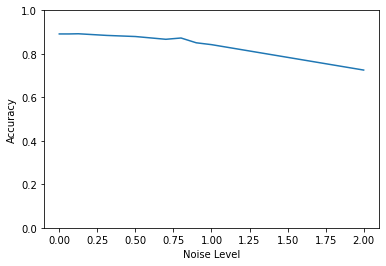

In [104]:
plt.plot(std_levels, percentages)
plt.ylim((0.0, 1.0))
plt.xlabel("Noise Level")
plt.ylabel("Accuracy")
plt.show()

In [99]:
model.save("model.h5")